# LightGBM

Original shape: (2154048, 19)
Inactive churners dropped: 299279
Shape after cleaning: (1854769, 19)
Shape after dropping useless columns: (1854769, 16)
[TOP_PACK] Number of rare packs (< 50) merged into 'RARE_PACK': 58

[PACK_GROUP] Distribution BEFORE merging rare groups:
PACK_GROUP
NO_PACK         603324
VOICE_ALLNET    384957
DATA_PACK       360442
VOICE_ONNET     321942
COMBO_PACK       67512
SOCIAL_PACK      66874
DAILY_PACK       45228
OTHER_PACK        3115
WIFI_PACK          651
RARE_PACK          432
EVC_PACK           139
WEEKLY_PACK         85
MONTHLY_PACK        68
Name: count, dtype: int64

[PACK_GROUP] Rare groups merged into 'OTHER_PACK': []

[PACK_GROUP] Final distribution:
PACK_GROUP
NO_PACK         603324
VOICE_ALLNET    384957
DATA_PACK       360442
VOICE_ONNET     321942
COMBO_PACK       67512
SOCIAL_PACK      66874
DAILY_PACK       45228
OTHER_PACK        3115
WIFI_PACK          651
RARE_PACK          432
EVC_PACK           139
WEEKLY_PACK         85
MONTHLY_PACK  

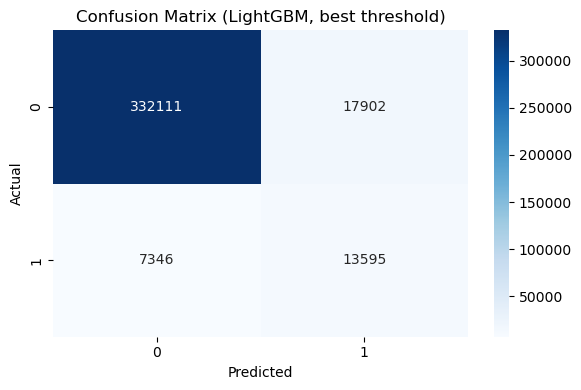

ROC-AUC: 0.9449104388788219


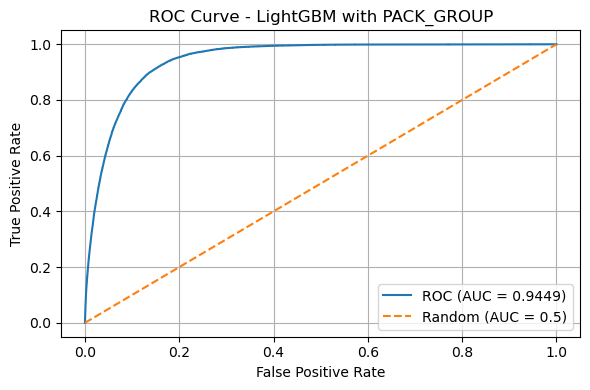

In [ ]:
# =============================================================================
# 0. IMPORT
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    accuracy_score
)

import lightgbm as lgb

# Make float output easier to read
pd.set_option('display.float_format', '{:.3f}'.format)


# =============================================================================
# 1. FUNCTION: CLEAN & STANDARDIZE TOP_PACK → TOP_PACK_CLEAN + PACK_GROUP
# =============================================================================
def prepare_top_pack(
    df,
    col_name="TOP_PACK",
    rare_threshold=50,
    new_clean_col="TOP_PACK_CLEAN",
    new_group_col="PACK_GROUP"
):
    """
    Clean and standardize the TOP_PACK column for churn modeling.

    Steps:
    1) Fill missing TOP_PACK with 'no_pack'
    2) Basic text cleaning (strip spaces)
    3) Merge rare packs (frequency < rare_threshold) into 'RARE_PACK'
    4) Map each cleaned pack name into a high-level group (PACK_GROUP)
    5) Merge very rare PACK_GROUPs into 'OTHER_PACK'

    Returns:
    - df with two new columns: new_clean_col and new_group_col
    """

    # 1. Fill missing values and clean basic string format
    df[col_name] = df[col_name].fillna("no_pack")
    top_pack_str = (
        df[col_name]
        .astype(str)      # ensure string type
        .str.strip()      # remove spaces at both ends
    )

    df[new_clean_col] = top_pack_str.copy()

    # 2. Rare handling for TOP_PACK (high-cardinality)
    pack_counts = df[new_clean_col].value_counts()
    rare_packs = pack_counts[pack_counts < rare_threshold].index

    df[new_clean_col] = df[new_clean_col].where(
        ~df[new_clean_col].isin(rare_packs),
        "RARE_PACK"
    )

    print(f"[TOP_PACK] Number of rare packs (< {rare_threshold}) merged into 'RARE_PACK': {len(rare_packs)}")

    # 3. Map cleaned pack names into PACK_GROUP
    def pack_group(x: str) -> str:
        s = str(x).lower()

        # No pack
        if s == "no_pack":
            return "NO_PACK"

        # Rare pack bucket
        if "rare_pack" in s:
            return "RARE_PACK"

        # Data / internet packs
        if ("data:" in s) or ("gprs" in s) or ("mifi" in s) or ("internet" in s):
            return "DATA_PACK"

        # WiFi / home internet
        if "wifi" in s:
            return "WIFI_PACK"

        # Voice on-net
        if "on net" in s or "on-net" in s or "onnet" in s:
            return "VOICE_ONNET"

        # Voice all-net (call to all operators)
        if "all-net" in s or "all net" in s or "allnet" in s:
            return "VOICE_ALLNET"

        # Combo / mixt packs (voice + data)
        if "mixt" in s or "mix " in s or "combo" in s:
            return "COMBO_PACK"

        # Social / youth packs (Facebook, Twitter, youth brands)
        if any(k in s for k in ["jokko", "ymgx", "youth", "facebook", "fb ", "twter", "twitter", "social"]):
            return "SOCIAL_PACK"

        # Daily packs
        if any(k in s for k in ["24h", "1day", "1 day", "daily", "one day"]):
            return "DAILY_PACK"

        # Weekly packs
        if "weekly" in s or "7d" in s or "7 d" in s or "week" in s:
            return "WEEKLY_PACK"

        # Monthly packs
        if any(k in s for k in ["monthly", "30d", "30 d", "month"]):
            return "MONTHLY_PACK"

        # EVC packs
        if "evc_" in s:
            return "EVC_PACK"

        # Sport packs (football, etc.)
        if "fifa" in s or "sport" in s:
            return "SPORT_PACK"

        # VAS / IVR / Radio / CRBT packs
        if any(k in s for k in ["vas(", "ivr", "radio", "crbt", "telmun"]):
            return "VAS_PACK"

        # Default bucket when nothing matches
        return "OTHER_PACK"

    df[new_group_col] = df[new_clean_col].apply(pack_group)

    print("\n[PACK_GROUP] Distribution BEFORE merging rare groups:")
    print(df[new_group_col].value_counts())

    # 4. Rare handling for PACK_GROUP (should be small already)
    group_counts = df[new_group_col].value_counts()
    rare_groups = group_counts[group_counts < 50].index.tolist()

    df[new_group_col] = df[new_group_col].where(
        ~df[new_group_col].isin(rare_groups),
        "OTHER_PACK"
    )

    print("\n[PACK_GROUP] Rare groups merged into 'OTHER_PACK':", rare_groups)
    print("\n[PACK_GROUP] Final distribution:")
    print(df[new_group_col].value_counts())

    return df


# =============================================================================
# 2. LOAD DATA
# =============================================================================
df = pd.read_csv("./dataset/Train.csv")   # change path if needed
print("Original shape:", df.shape)

# =============================================================================
# 3. CLEANING – DROP INACTIVE CHURN
#    Condition: all usage = 0 and CHURN = 1
#    Idea: if a customer has no usage but is marked as churn,
#    it may be noise or wrong label, so we remove these rows.
# =============================================================================

# Usage-related columns (extend if needed)
usage_cols = [
    "MONTANT",
    "REVENUE",
    "ON_NET",
    "ORANGE",
    "TIGO",
    "ZONE1",
    "ZONE2"
]

# Replace missing with 0, then sum all usage columns
usage_sum = df[usage_cols].fillna(0).sum(axis=1)

# Mask for "inactive churners"
inactive_churn_mask = (usage_sum == 0) & (df["CHURN"] == 1)

print("Inactive churners dropped:", inactive_churn_mask.sum())

# Keep rows that are NOT inactive churners
df = df[~inactive_churn_mask].copy()
print("Shape after cleaning:", df.shape)

# =============================================================================
# 4. DROP USELESS COLUMNS (ID, derived, no information)
# =============================================================================
drop_cols = []
for col in ["ARPU_SEGMENT", "MRG", "user_id"]:
    if col in df.columns:
        drop_cols.append(col)

df = df.drop(columns=drop_cols)
print("Shape after dropping useless columns:", df.shape)

# =============================================================================
# 5. HANDLE MISSING VALUES
#    - REGION: fill with 'unknown'
#    - TOP_PACK: will be handled in prepare_top_pack()
#    - Numeric usage + FREQ_TOP_PACK + FREQUENCE_RECH + FREQUENCE + DATA_VOLUME: fill 0
# =============================================================================

# Fill missing REGION
if "REGION" in df.columns:
    df["REGION"] = df["REGION"].fillna("unknown")

# Extra numeric columns related to usage
extra_numeric_cols = [
    "FREQUENCE_RECH",
    "FREQUENCE",
    "DATA_VOLUME",
    "FREQ_TOP_PACK"
]

# Fill numeric usage-like columns with 0
for col in usage_cols + extra_numeric_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0)

# =============================================================================
# 6. PREPARE TOP_PACK → TOP_PACK_CLEAN + PACK_GROUP
# =============================================================================
df = prepare_top_pack(
    df,
    col_name="TOP_PACK",
    rare_threshold=50,
    new_clean_col="TOP_PACK_CLEAN",
    new_group_col="PACK_GROUP"
)

# =============================================================================
# 7. CONVERT SAFE FLOAT COLUMNS TO INT
#    If a float column only contains integer-like values, convert to Int64.
# =============================================================================
def convert_float(df_):
    for col in df_.select_dtypes(include="float").columns:
        # if all non-missing values are whole numbers, convert to Int64
        if (df_[col].dropna() == np.floor(df_[col].dropna())).all():
            df_[col] = df_[col].astype("Int64")
    return df_

df = convert_float(df)

# =============================================================================
# 8. LABEL ENCODING FOR CATEGORICAL COLUMNS (REGION, TENURE, PACK_GROUP)
#    We keep numeric encoded versions for modeling.
# =============================================================================
label_cols = []
for c in ["REGION", "TENURE", "PACK_GROUP"]:
    if c in df.columns:
        label_cols.append(c)

for col in label_cols:
    le = LabelEncoder()
    df[col + "_enc"] = le.fit_transform(df[col].astype(str))

# Drop raw string columns for modeling (optional but cleaner)
df = df.drop(columns=label_cols + ["TOP_PACK", "TOP_PACK_CLEAN"])

print("\nDataFrame head after all cleaning + TOP_PACK grouping + encoding:")
print(df.head())

# =============================================================================
# 9. TRAIN / TEST SPLIT
# =============================================================================
X = df.drop("CHURN", axis=1)
y = df["CHURN"]

# Drop rows where 'CHURN' is NaN before splitting
df_cleaned = df.dropna(subset=['CHURN'])
X = df_cleaned.drop("CHURN", axis=1)
y = df_cleaned["CHURN"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nTrain shape:", X_train.shape, " Test shape:", X_test.shape)
print("\nTrain target distribution:")
print(y_train.value_counts(normalize=True))

# =============================================================================
# 10. HANDLE CLASS IMBALANCE (scale_pos_weight for LightGBM)
# =============================================================================
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos
print("\nscale_pos_weight:", scale_pos_weight)

# =============================================================================
# 11. TRAIN LIGHTGBM MODEL
# =============================================================================
lgb_model = lgb.LGBMClassifier(
    boosting_type="gbdt",
    objective="binary",
    n_estimators=1200,
    learning_rate=0.03,
    num_leaves=64,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

print("\nTraining LightGBM...")
lgb_model.fit(X_train, y_train)
print("Training done.")

# =============================================================================
# 12. THRESHOLD OPTIMIZATION (maximize F1 for churn – class 1)
# =============================================================================
y_prob = lgb_model.predict_proba(X_test)[:, 1]

best_th = 0.5
best_f1 = 0.0

# Scan many thresholds from 0.01 to 0.99
for t in np.linspace(0.01, 0.99, 300):
    y_pred_temp = (y_prob >= t).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_temp).ravel()

    prec = tp / (tp + fp + 1e-8)
    rec = tp / (tp + fn + 1e-8)
    f1 = 2 * prec * rec / (prec + rec + 1e-8)

    if f1 > best_f1:
        best_f1 = f1
        best_th = t

print("\n===== BEST THRESHOLD (opt F1 for churn) =====")
print("Threshold:", best_th)
print("Best F1 (churn):", best_f1)

# =============================================================================
# 13. FINAL EVALUATION WITH BEST THRESHOLD
# =============================================================================
y_pred = (y_prob >= best_th).astype(int)

print("\n=== FINAL CLASSIFICATION REPORT (LightGBM + PACK_GROUP) ===")
print(classification_report(y_test, y_pred))

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (LightGBM, best threshold)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC-AUC
auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC:", auc)

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LightGBM with PACK_GROUP")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


=========== FULL FEATURE IMPORTANCE (LightGBM) ===========
           feature  importance
10      REGULARITY        9072
5           ON_NET        8317
6           ORANGE        7773
2          REVENUE        7633
4      DATA_VOLUME        6966
0          MONTANT        6431
7             TIGO        5469
3        FREQUENCE        5066
11   FREQ_TOP_PACK        4185
1   FREQUENCE_RECH        4107
12      REGION_enc        4035
8            ZONE1        2193
14  PACK_GROUP_enc        1795
9            ZONE2        1511
13      TENURE_enc        1047


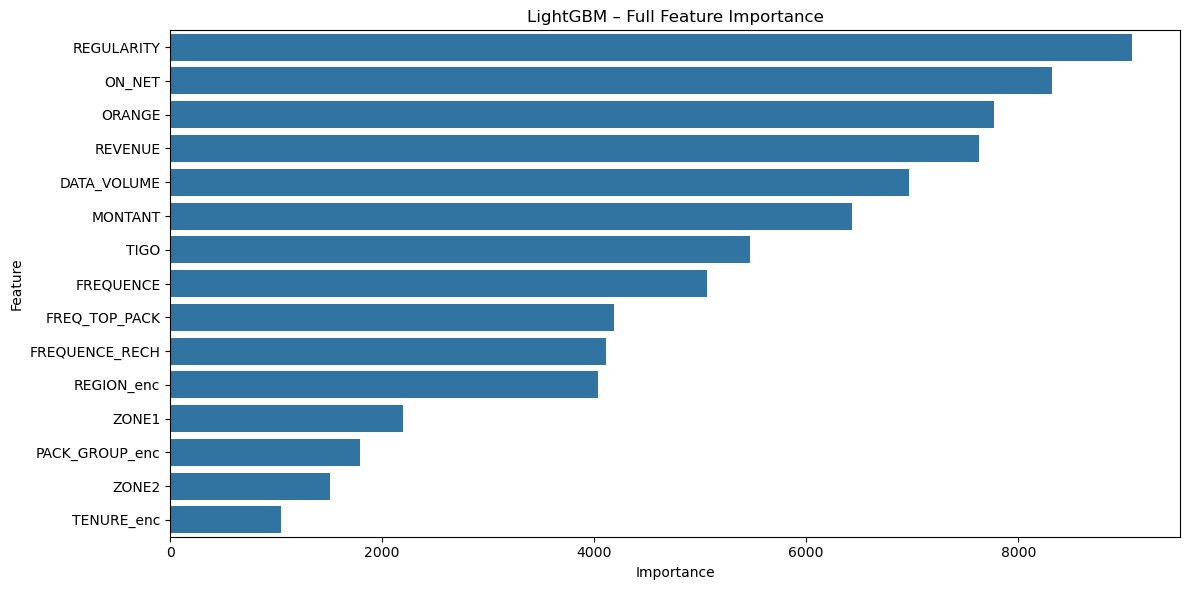

In [ ]:
# =============================================================================
# 14. FEATURE IMPORTANCE – LIGHTGBM
# =============================================================================

# Lấy tên feature và importance từ model
feature_names = X_train.columns
importances = lgb_model.feature_importances_   # mặc định kiểu 'split'

# Đưa vào DataFrame cho dễ xem
fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
})

# Sắp xếp giảm dần theo độ quan trọng
fi_df = fi_df.sort_values("importance", ascending=False)

print("\n=========== FULL FEATURE IMPORTANCE (LightGBM) ===========")
print(fi_df)

# Vẽ biểu đồ toàn bộ feature importance
plt.figure(figsize=(12, max(6, len(fi_df) * 0.25)))  # auto cao theo số feature
sns.barplot(
    data=fi_df,
    x="importance",
    y="feature",
    orient="h"
)
plt.title("LightGBM – Full Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
